# Project Milestone One: Gathering your Team, Understanding the Problem,  Exploring the Data

#### Due: Midnight on July 20th (with 2-hour grace period)

#### There will be no late period on this homework, as we need to start manual grading immediately! 



### What We Will Do in This Milestone Assignment

1. You will convene your team and fill out the Team Contract (in the Homework Repo), to be submitted to Gradescope.
2. You must select a team leader for the purpose of submitting this notebook, after the team collaborates to complete the assignment. This <a href=https://guides.gradescope.com/hc/en-us/articles/21863861823373-Adding-Group-Members-to-a-Submission>link</a> describes how to add group members to your leader's submission. 
3. At the conclusion of your work on this Milestone, you will complete an Individual Evaluation of your team's work (in the Homework Repo) and upload it *individually* to Gradescope.
4. We will follow a simplified version of the **Machine Learning Project Checklist** in Appendix A in our textbook *Hands-On Machine Learning* (pp.779):  

>Part 1:	Frame the problem and look at the big picture  
Part 2: Download and perform preliminary exploration of the data  
Part 3: Clean the Data: Drop, Impute, and Encode   
Part 4: Explore Feature Relationships  
Part 5: Investigate Feature Engineering options to better expose the underlying data patterns  

### The Dataset

All teams will use the same dataset. It is a smaller version of the Zillow housing dataset that was used in the
Zillow Million Dollar Prize which ran on Kaggle in 2017 (sorry, the contest is closed, so you can't win any money
with this project!).  We will try to predict the assessed tax value (`'taxvaluedollarcnt'`) of the property from a large collection
of descriptors. Some features are closely related and some are obviously useless.  There are potential outliers and also quite a few missing values. 

This is a good example of a dataset which has not been predigested for you on Kaggle, and should give you a good chance to
try all the various tools in your toolbox!


In [56]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
import sklearn
from sklearn.model_selection import (
    train_test_split, 
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV, 
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

# Kaggle and Progress Tracking
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))



## Prelude: Download the Zillow Housing Dataset 

The code cell below will load the dataset for you.    

> **Notice that before downloading, this cell first checks whether the files already exist.** 

For a detailed description of the dataset features, please refer to  **Appendix 1** below. 

**Note:** Do **not** perform a train/test split for this milestone (unlike HOML suggests), since you need to do the split **after** any data preparation and feature engineering. You can wait until Milestone 2 to do the split. 

In [2]:

url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File downloaded successfully.


## Part 1: Frame the problem and look at the big picture [3 pts]

This part is a bit vague, since this project is not taking place in an actual business, but for the sake of exercizing all the steps, **pretend** that you are working at Zillow as a data analyst and are given this dataset and asked to
- Analyze and understand the data; 
- Create a regression model;
- Give a presentation to the marketing team about your results.  

#### **1 Discussion:** 

AFTER doing your EDA, come back and answer each of the following 3 questions in a *concise and informative paragraph between the lines;* you may wish to use your own business or home-buying experience, or to do some online research about the issues before you propose your ideas. (Don't stress about this, but *humor your professor and give it your best shot!*)


**1.1:**  What is the objective of this project in business terms?


The objective of this project is to build a model that can estimate home values based on available property features. From a business perspective, this helps Zillow to enhance its estimate value tool, improve customer engagement, and provide more reliable pricing guidance to its customers. It also helps Zillow to stay competitive in the real estate tech market by strengthening trust in its pricing algorithms.

**1.2:**  How will your solution be used?


Our solution can use insights from the model we introduce for the identifying feaures with most impact price, enabling to help in marketing campaigns, highlight property traits, targetted audience & regional price based trends to help in strategic decisions. 

**1.3:**  How should success (or failure) be measured?


Our success can be measured by model's prediction on performance, specifically how acurate it estimates value to the actual sales price. For this MAE & RMSE tests will be critical. Failure can be indicated by high prediction errors and overfitting of data. 

## Part 2: Download and perform preliminary exploration of the data [4 pts]

### Part 2.A: Load the data into a dataframe and study each feature/column and its characteristics:
- Name
- Type (categorical, int/float, text, etc.)
- Apparent usefulness for the task
- Approximate % of missing values
- How many unique values

**Note:** The **target** is the last column `'taxvaluedollarcnt'` -- pay particular attention to this during the EDA process. 
  
Hint: Just use `.head()`, `.info()`, and `.nunique()`.

In [3]:
#Load Dataset
df = pd.read_csv(filename)

# Display the first few rows of the dataset
print("#############################")
print("Dataset loaded successfully.")
print("#############################\n")
display(df.head())


# Display basic information about the dataset
print("#############################")
print("Dataset Information:")
print("#############################\n")
df.info()

#############################
Dataset loaded successfully.
#############################



,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,fireplaceflag,assessmentyear,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxvaluedollarcnt
0,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,NaN,...,NaN,NaN,1998.0,NaN,NaN,2016.0,NaN,NaN,6.059063e+13,1023282.0
1,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,NaN,NaN,1967.0,1.0,NaN,2016.0,NaN,NaN,6.111001e+13,464000.0
2,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,NaN,NaN,1962.0,1.0,NaN,2016.0,NaN,NaN,6.059022e+13,564778.0
3,12177905,NaN,NaN,NaN,3.0,4.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1970.0,NaN,NaN,2016.0,NaN,NaN,6.037300e+13,145143.0
4,10887214,1.0,NaN,NaN,3.0,3.0,NaN,8.0,3.0,NaN,...,NaN,NaN,1964.0,NaN,NaN,2016.0,NaN,NaN,6.037124e+13,119407.0


#############################
Dataset Information:
#############################

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77613 entries, 0 to 77612
Data columns (total 55 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      77613 non-null  int64  
 1   airconditioningtypeid         25007 non-null  float64
 2   architecturalstyletypeid      207 non-null    float64
 3   basementsqft                  50 non-null     float64
 4   bathroomcnt                   77579 non-null  float64
 5   bedroomcnt                    77579 non-null  float64
 6   buildingclasstypeid           15 non-null     float64
 7   buildingqualitytypeid         49809 non-null  float64
 8   calculatedbathnbr             76963 non-null  float64
 9   decktypeid                    614 non-null    float64
 10  finishedfloor1squarefeet      6037 non-null   float64
 11  calculatedfinishedsquarefeet  77378 n

In [4]:
#Load Dataset


#Display number of unique values in each column
print("############################################")
print("Number of unique values in each column:")
print("############################################\n")
unique_counts = df.nunique()
print(unique_counts)



############################################
Number of unique values in each column:
############################################

parcelid                        77414
airconditioningtypeid               5
architecturalstyletypeid            5
basementsqft                       43
bathroomcnt                        22
bedroomcnt                         16
buildingclasstypeid                 2
buildingqualitytypeid              12
calculatedbathnbr                  21
decktypeid                          1
finishedfloor1squarefeet         1787
calculatedfinishedsquarefeet     4972
finishedsquarefeet12             4868
finishedsquarefeet13               13
finishedsquarefeet15             1724
finishedsquarefeet50             1807
finishedsquarefeet6               350
fips                                3
fireplacecnt                        5
fullbathcnt                        13
garagecarcnt                       14
garagetotalsqft                   839
hashottuborspa                   

In [5]:
# Missing values per column
print("############################################")
print("Missing values per column:")
print("############################################\n")
missing_counts = df.isnull().mean() * 100
print(missing_counts[missing_counts > 0])

############################################
Missing values per column:
############################################

airconditioningtypeid           67.779882
architecturalstyletypeid        99.733292
basementsqft                    99.935578
bathroomcnt                      0.043807
bedroomcnt                       0.043807
buildingclasstypeid             99.980673
buildingqualitytypeid           35.823895
calculatedbathnbr                0.837489
decktypeid                      99.208895
finishedfloor1squarefeet        92.221664
calculatedfinishedsquarefeet     0.302784
finishedsquarefeet12             4.754358
finishedsquarefeet13            99.945885
finishedsquarefeet15            96.099880
finishedsquarefeet50            92.221664
finishedsquarefeet6             99.502661
fips                             0.043807
fireplacecnt                    89.320088
fullbathcnt                      0.837489
garagecarcnt                    67.118910
garagetotalsqft                 67.118910


In [6]:
# Column type summary table
summary = pd.DataFrame({
    "Type": df.dtypes,
    "Missing %": missing_counts,
    "Unique Values": df.nunique(),
})
print("############################################")
print("Column Type Summary:")
print("############################################\n")
display(summary)

############################################
Column Type Summary:
############################################



,Type,Missing %,Unique Values
parcelid,int64,0.000000,77414
airconditioningtypeid,float64,67.779882,5
architecturalstyletypeid,float64,99.733292,5
basementsqft,float64,99.935578,43
bathroomcnt,float64,0.043807,22
bedroomcnt,float64,0.043807,16
buildingclasstypeid,float64,99.980673,2
buildingqualitytypeid,float64,35.823895,12
calculatedbathnbr,float64,0.837489,21
decktypeid,float64,99.208895,1


#### **2.A Discussion:** Answer the following questions.

**2.A.1:**  Which features are categorical?

In [7]:
object_columns = df.select_dtypes(include='object').columns.tolist()
print("Columns with dtype 'object':")
print(object_columns)

Columns with dtype 'object':
['hashottuborspa', 'propertycountylandusecode', 'propertyzoningdesc', 'fireplaceflag', 'taxdelinquencyflag']


**Answer:** 
Following are the features which are categorical:
- hashottuborspa
- propertycountylandusecode
- propertyzoningdesc
- fireplaceflag
- taxdelinquencyflag
- regionidcounty



**2.A.2:**  Are there any features which appear at first glance to be **useless** for the business purpose of this project and should be deleted?  Give examples and describe your reasoning briefly. 

**Yes, columns like "parcelid" and "id" serve as unique identifiers for each row and provide no predictive value. Similarly, text fields like "propertycountylandusecode" and/or "rawcensustractandblock" may be difficult to interpret without external context or mapping tables and may be excluded unless used into more useful features.**

**2.A.3:**  Are there any features which appear to be **useless** because of the percentage of missing values?  If so, give an example. 

**Yes, features like finishedsquare1, finishedsquare2, or basementsqft often have over 95% missing values in real estate datasets. These features likely lack enough data to be reliable for modeling and could be dropped**

**2.A.4:**  Are there any features which appear to be **useless** because of the number of unique values?  If so, give an example. 

**Yes, features such as parcelid or transactiondate often have extremely high cardinality. Many unique values with little repetition which makes them poor predictors.**

### Part 2.B: Exploratory Data Analysis (EDA) -- Feature-Level Visualization  

- To get an overview, generate histograms for all features using `df.hist()`  (Hint: increase the figsize and set the layout to `(-1,m)` to get  `m` columns and as many rows as necessary.)
- Generate individual visualizations for the **target and three (3)** other interesting-looking features in the dataset (i.e., a total of 4):  
    - Use appropriate plot types (e.g., histograms and boxplots for numerical features, bar plots for categorical features) to understand distributions and identify potential outliers for these three.
    - Use as many code cells as you need, and give comments describing what each cell does.
    - Answer the discussion question posed (you should choose 3 features for which you can say something interesting in the discussion).  

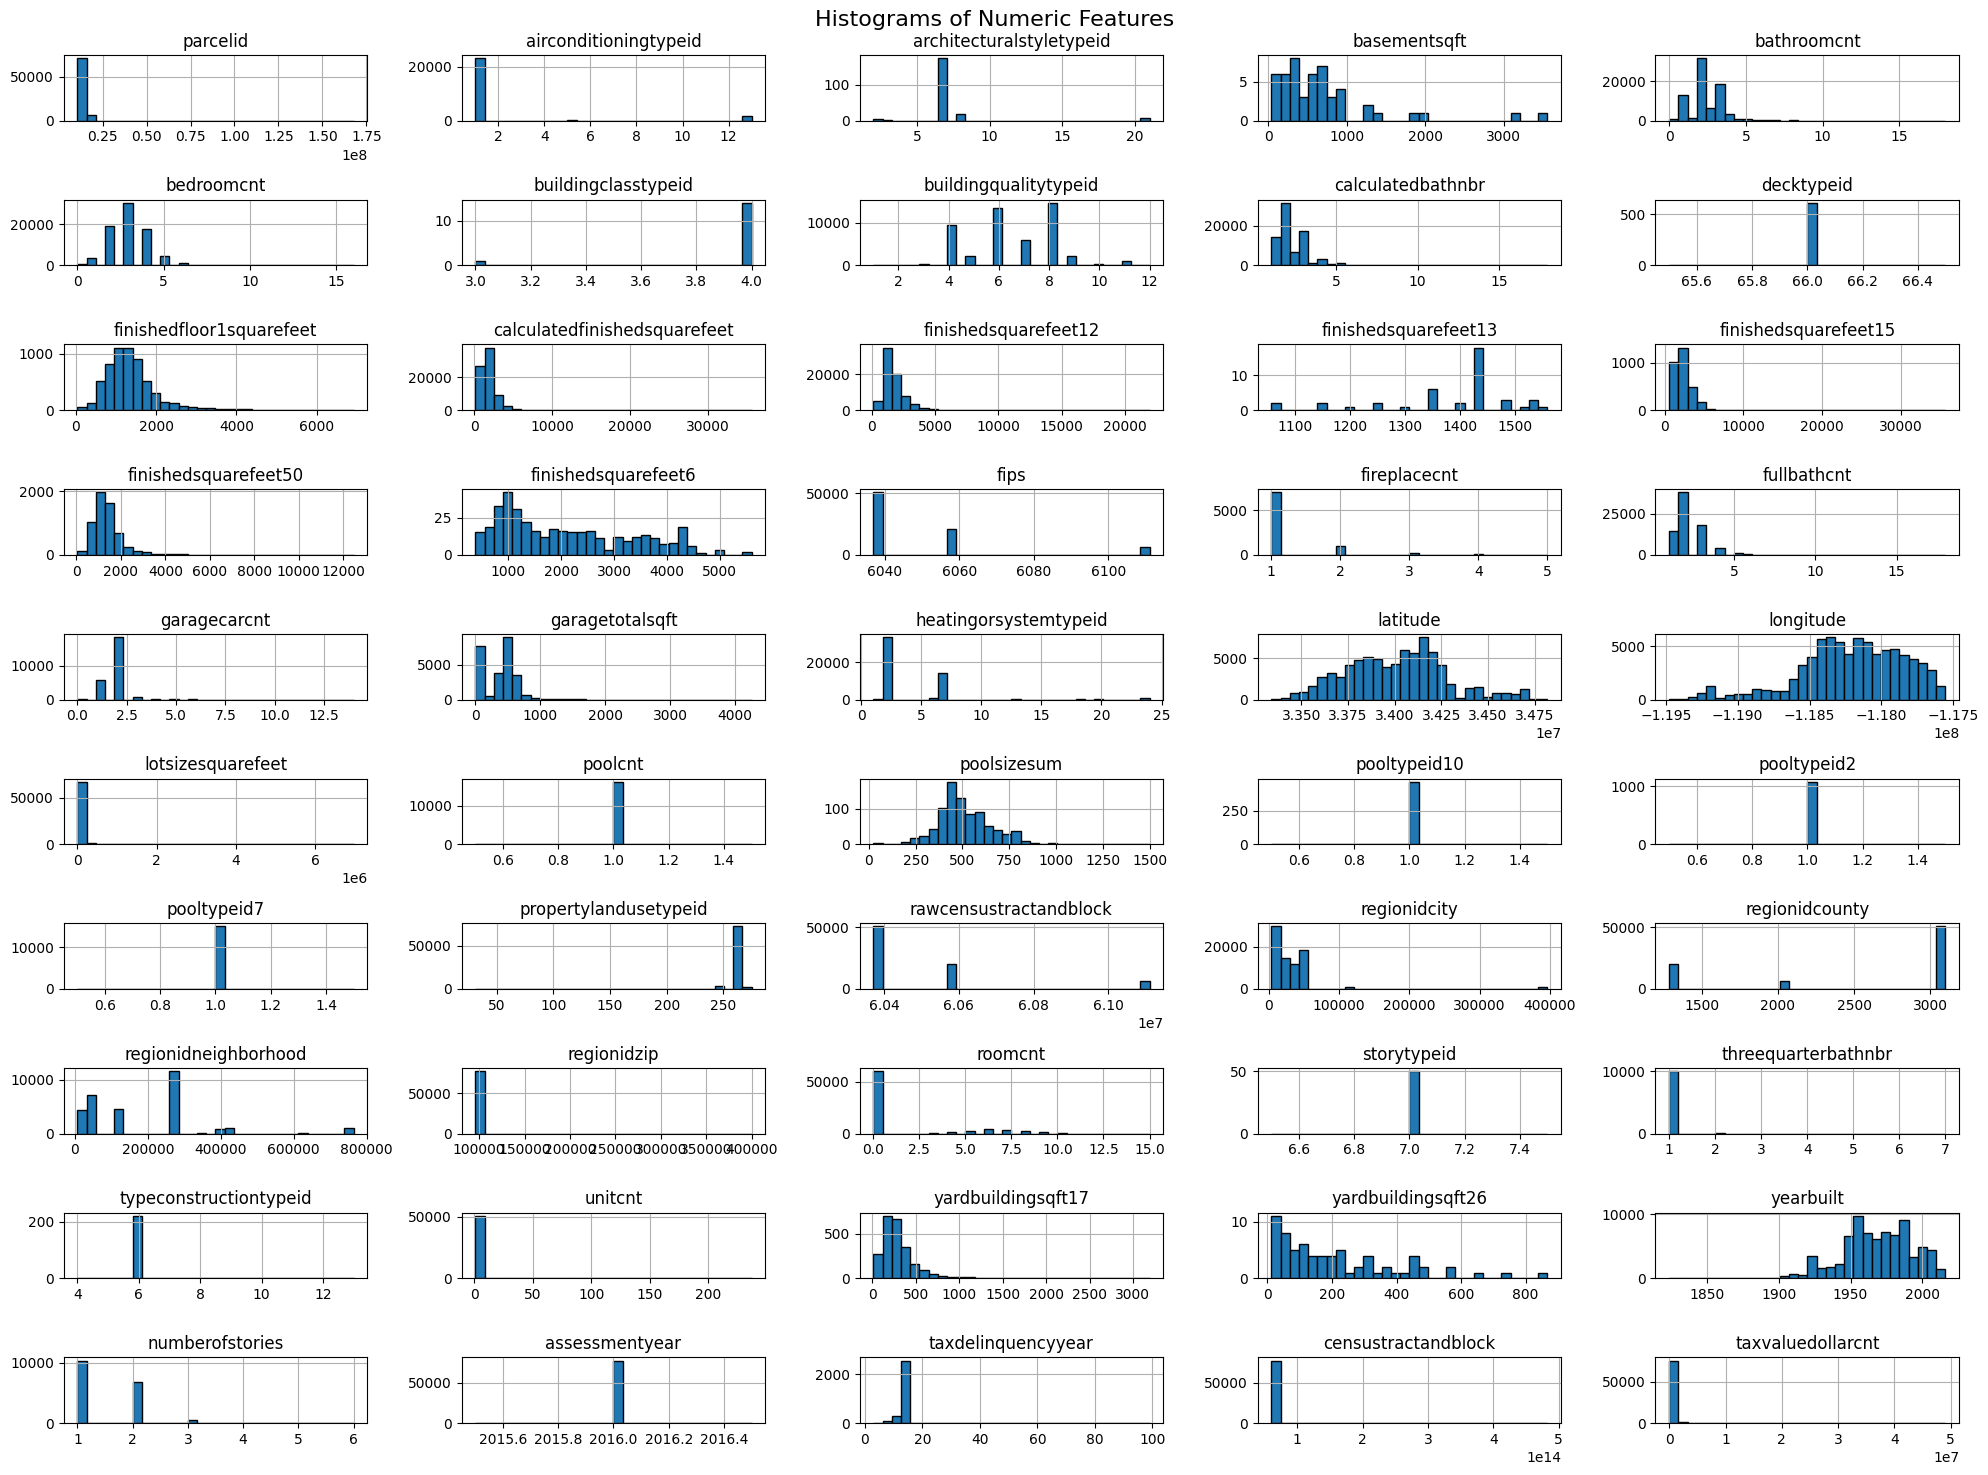

In [8]:
# Plot histograms for all numeric features
df.hist(figsize=(20, 15), layout=(-1, 5), bins=30, edgecolor='black')
plt.suptitle("Histograms of Numeric Features", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()


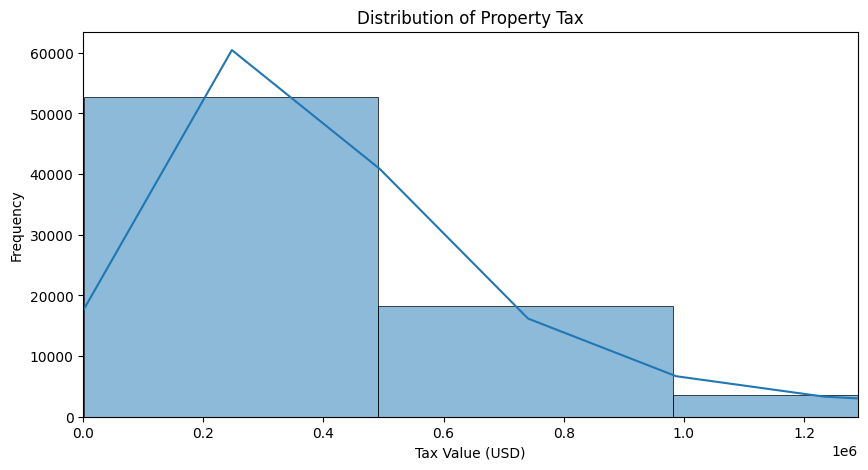

In [9]:
# Plot distribution of the target: taxvaluedollarcnt
plt.figure(figsize=(10, 5))
sns.histplot(df['taxvaluedollarcnt'], bins=100, kde=True)
plt.title('Distribution of Property Tax')
plt.xlabel('Tax Value (USD)')
plt.ylabel('Frequency')
plt.xlim(0, df['taxvaluedollarcnt'].quantile(0.95))  # optional: limit extreme outliers
plt.show()

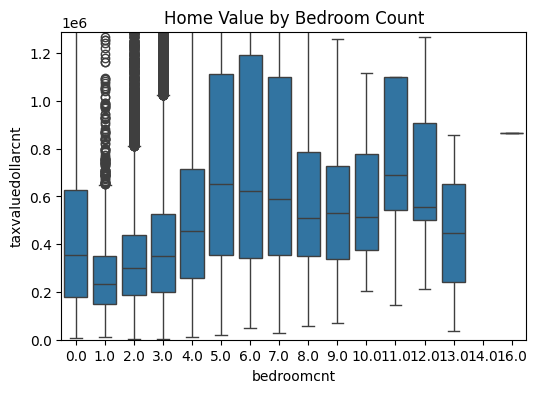

In [10]:
# Plot boxplot of taxvaluedollarcnt by bedroom count
plt.figure(figsize=(6, 4))
sns.boxplot(x='bedroomcnt', y='taxvaluedollarcnt', data=df)
plt.title('Home Value by Bedroom Count')
plt.ylim(0, df['taxvaluedollarcnt'].quantile(0.95))
plt.show()

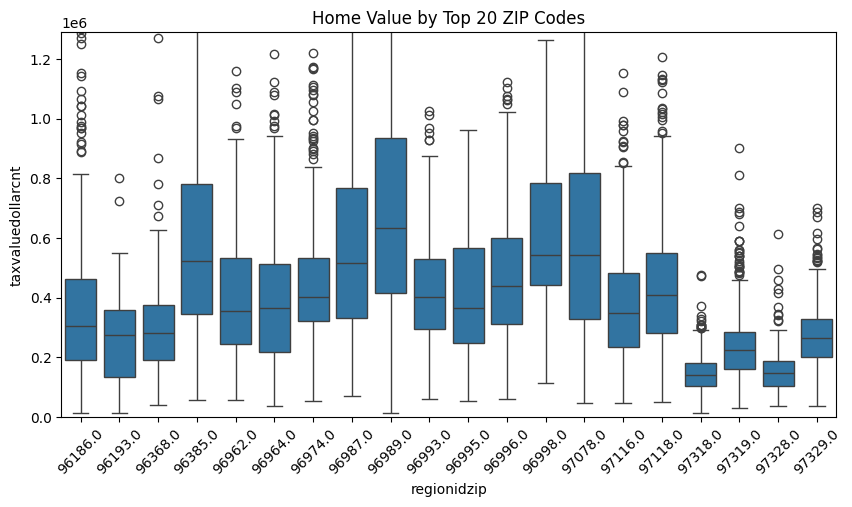

In [11]:
# Plot boxplot of taxvaluedollarcnt by top 10 ZIP codes

top_zips = df['regionidzip'].value_counts().head(20).index
df_top_zip = df[df['regionidzip'].isin(top_zips)]

plt.figure(figsize=(10, 5))
sns.boxplot(x='regionidzip', y='taxvaluedollarcnt', data=df_top_zip)
plt.title('Home Value by Top 20 ZIP Codes')
plt.xticks(rotation=45)
plt.ylim(0, df['taxvaluedollarcnt'].quantile(0.95))
plt.show()

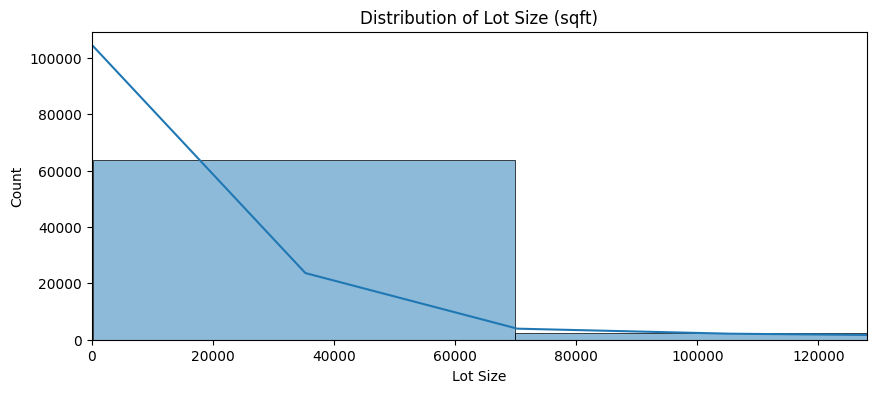

In [12]:
# Plot distribution of lot sizes
plt.figure(figsize=(10, 4))
sns.histplot(df['lotsizesquarefeet'].dropna(), bins=100, kde=True)
plt.title("Distribution of Lot Size (sqft)")
plt.xlabel("Lot Size")
plt.xlim(0, df['lotsizesquarefeet'].quantile(0.95))
plt.show()

#### **2.B Discussion:** Describe in a paragraph what you learned in your detailed examination of the features you explored:
- What is the distribution (normal, exponential, etc.) if any?
- Any problems (e.g., outliers, any odd characteristics)?
- Anything else interesting? Why did you choose it?


**The target variable "taxvaluedollarcnt", displays a right skewed distribution, with the majority of properties valued under $500,000 and a long tail of high value homes extending well beyond one million. This shows the presence of significant outliers, which could disturb model training if not addressed through transformation or capping.**


**The bedroomcnt feature appeared more discrete and bell-shaped, with most homes having between 2 and 4 bedrooms, indicating that this is a reliable and normally distributed categorical variable.. however, beyond 6 bedrooms, the relationship weakens and becomes more predictable due to the rarity of such large homes.**

**The "regionidzip" feature reveals substantial geographic variation in home values. Certain ZIP codes consistently show higher median property values, indicating that location is a strong predictor of home price. Lastly, "lotsizesquarefeet" is also highly skewed, with most properties clustered around smaller lot sizes and a few very large lots is showing the distribution’s tail. These outliers may benefit from log or binning. We chose these features because they are both highly relevant to real estate pricing and shows distinct patterns that will help in feature engineering and model selection.**

Lot Size:
1. Highly right-skewed and non-normal. Long-tailed distribution -> possibly exponential
2. Most values were clustered at the lower end and a few extreme outliers stretched into the millions.
3. The graph looks interesting because of its shape.

Bedroom Count:
1. Looks like an unimodal distribution. Majoirty of them have 2-4 bedrooms.
2. Outliers -> 6 rooms ?
3. The room numbers are direcly related to the tax value.

## Part 3:  Clean the Data: Drop, Impute, and Encode [6 pts]



**Important Notes:**
- You should review your Homework 4 before doing this section!
- Create new names for modified data at each stage to avoid problems with global variables.
- Whenever possible, write functions for all data transformations you apply, for these reasons:
    - So you can easily prepare the data the next time you get a fresh dataset
    - So you can apply these transformations in future projects
    - To clean and prepare new data instances once your solution is live
    - To make it easy to treat your preparation choices as hyperparameters
    - [To apply the same transformations to your test set if train/test split already done -- not applicable here]

### Part 3.A: Drop features you judge to be unsuitable for the regression task

Your call, based on any research you can do to understand the feature (hopefully IRL you would have a domain expert to help with this, but do your best).   

Note: Do not drop features because of too many missing values, that's the next task! 

In [80]:
def drop_features(df):
    cols_to_drop = [
    'parcelid',
    'rawcensustractandblock',  
    'censustractandblock',  
    'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip',  
    'assessmentyear',  
    'propertycountylandusecode', 'propertyzoningdesc',  
    'taxdelinquencyflag', 'taxdelinquencyyear',  
    'fireplaceflag'
    ]
    df_dropped = df.drop(columns=[col for col in cols_to_drop if col in df.columns])
    return df_dropped

# Apply to original dataframe
df_cleaned_3a = drop_features(df)
print("Dropped features. Remaining columns:", df_cleaned_3a.shape[1])

Dropped features. Remaining columns: 42


#### **3.A Discussion:** Justify in a paragraph your decisions about which features to drop. 



1. parcelid - Unique ID, not predictive
2. rawcensustractandblock, censustractandblock  - Coded geographic identifier, not interpretable without external context
3. regionidcity, regionidcounty, regionidneighborhood, regionidzip - Categorical region codes with limited modeling value unless processed
3. assessmentyear - Often constant
4. propertycountylandusecode, propertyzoningdesc - Text-based codes that are hard to interpret without mapping
5. taxdelinquencyflag, taxdelinquencyyear - May not affect tax value prediction directly
6. fireplaceflag - Redundant with 'fireplacecnt'

**In this step, We dropped features that are unsuitable for regression modeling due to their lack of predictive value or general relevance. Unique identifiers such as parcelid were removed because they are specific to each property and carry no significant information required for prediction. Coded text fields like propertyzoningdesc and propertycountylandusecode were excluded due to their high cardinality and lack of standardized interpretation, which would require external reference tables to be meaningful. We also removed features like transactiondate, rawcensustractandblock, and censustractandblock, which are either too granular or not representative of significant property characteristics. Additionally, assessmentyear was nearly constant across observations and thus offers no variation for modeling. Lastly, We dropped taxdelinquencyflag and taxdelinquencyyear due to high missingness and limited relevance within a single snapshot of data. Dropping these features helps streamline the dataset and improve model interpretability and generalizability.**

### Part 3.B: Drop **features** with "too many" null values

Your code in the next cell(s). Make a judgement call about what "too many" means and briefly describe your reasoning in the discussion.   

Note: "Too many" may depend on what the non-null values look like, be sure to investigate carefully. 

In [86]:
def drop_missing_features(df, threshold=0.7):   #As more than 70% of the data is missing
    missing_ratio = df.isnull().mean()
    to_drop = missing_ratio[missing_ratio > threshold].index
    print(f"Dropping {len(to_drop)} features with greater than {int(threshold*100)}% missing values.")
    return df.drop(columns=to_drop)

df_cleaned_3b = drop_missing_features(df_cleaned_3a)

Dropping 23 features with greater than 70% missing values.


#### **3.B Discussion:** In a paragraph, explain your decision about which features were dropped



**To clean the dataset more effectively, We dropped features with more than 70% missing values. This threshold was chosen to keep a balance between removing features that are missing most of the informative data and retaining potentially valuable variables that might otherwise be lost with a more aggressive cutoff. At this level, 23 features were removed. These included variables such as basementsqft, finishedsquarefeet13, and various pooltypeid columns, which had very limited coverage and would be unreliable or required for the model. Retaining features with excessive missing data can introduce noise, bias, or instability into the regression model. By filtering them out early, We’ve simplified the data structure and improved the foundation for further preprocessing and model training.**

### Part 3.C: Drop Problematic **samples** 

There could be several reasons why you might want to drop a sample:
- It has  "too many" null values 
- It has a null value in the target
- It contains outliers, especially in the target



Your code in the next cell(s). Make a judgement call about which samples should be dropped and briefly describe your reasoning in the discussion.   


In [87]:
# Drop rows where the target is missing
df_cleaned_3c = df_cleaned_3b.dropna(subset=['taxvaluedollarcnt'])
print(f"Rows after dropping missing target: {df_cleaned_3c.shape[0]}")

Rows after dropping missing target: 77578


In [88]:
#Drop sample with too many null values

row_null_threshold = 0.3 # Drop rows with more than 30% missing values
row_missing = df_cleaned_3c.isnull().mean(axis=1)
df_cleaned_3c = df_cleaned_3c[row_missing <= row_null_threshold]
print(f"Rows after dropping samples with greater than 30% missing: {df_cleaned_3c.shape[0]}")

Rows after dropping samples with greater than 30% missing: 76878


In [89]:
# Drop outliers beyond 99th percentile of the target
q99 = df_cleaned_3c['taxvaluedollarcnt'].quantile(0.99)
df_cleaned_3c = df_cleaned_3c[df_cleaned_3c['taxvaluedollarcnt'] <= q99]
print(f"Rows after dropping target outliers: {df_cleaned_3c.shape[0]}")

Rows after dropping target outliers: 76109


#### **3.C Discussion:** In a short paragraph, explain your decision about which samples were dropped


**To improve data quality and model stability, We dropped three types of problematic samples. First, We removed rows with missing values in the target variable taxvaluedollarcnt, since these cannot be used in supervised regression. Next, We dropped samples with more than 30% missing feature values, as they have insufficient information for reliable analysis. Finally, We identified and removed outliers in the target by excluding the top 1% of property values, based on the distribution’s heavy right-skew. Visualizations confirmed that these outliers represent extreme cases that could influence the regression model. Removing them helps focus the analysis on the typical property value range and supports more generalized predictions.

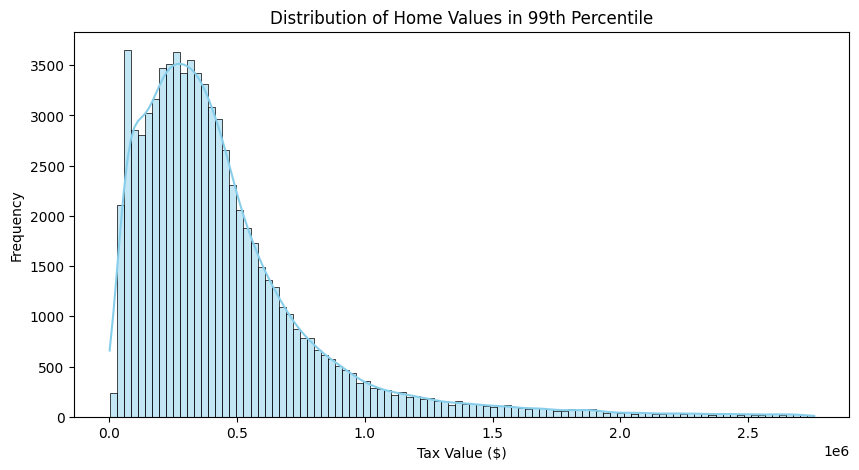

In [90]:
q99 = df_cleaned_3b['taxvaluedollarcnt'].quantile(0.99)

plt.figure(figsize=(10, 5))
sns.histplot(df_cleaned_3b[df_cleaned_3b['taxvaluedollarcnt'] <= q99]['taxvaluedollarcnt'],
             bins=100, kde=True, color='skyblue')
plt.title('Distribution of Home Values in 99th Percentile')
plt.xlabel('Tax Value ($)')
plt.ylabel('Frequency')
plt.show()

### Part 3.D: Impute for the remaining missing values

Review the methods for imputation in **Appendix 2** and choose how you will impute the remainder of the missing values. Note:
- Consider whether different methods are justified for different features.
- In the next cells, apply your imputation methods to the dataset so that no null values remain after this step.
- Answer the discussion question.

In [91]:
# Impute missing values in the dataset
def impute_data(df):
    df_imputed = df.copy()

    # Numeric and categorical columns
    num_cols = df_imputed.select_dtypes(include=['float64', 'int64']).columns
    cat_cols = df_imputed.select_dtypes(include='object').columns

    # Impute numeric columns with median
    if len(num_cols) > 0:
        median_imputer = SimpleImputer(strategy='median')
        df_imputed[num_cols] = median_imputer.fit_transform(df_imputed[num_cols])
        print("Numeric columns after imputation:", num_cols.tolist())

    # Impute categorical columns with mode
    if len(cat_cols) > 0:
        mode_imputer = SimpleImputer(strategy='most_frequent')
        df_imputed[cat_cols] = mode_imputer.fit_transform(df_imputed[cat_cols])
        print("\nCategorical columns after imputation:", cat_cols.tolist())
    return df_imputed

df_cleaned_3d = impute_data(df_cleaned_3c)
print("Remaining missing values:", df_cleaned_3d.isnull().sum().sum())




Numeric columns after imputation: ['airconditioningtypeid', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet', 'propertylandusetypeid', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt', 'taxvaluedollarcnt']
Remaining missing values: 0


#### **3.D Discussion:**  Describe in a paragraph your decisions about which methods you used to impute missing values in the dataset


**To impute the remaining missing values, we applied different strategies based on the type and nature of each feature. For numerical columns, we used median imputation, which is robust to skewed distributions and outliers. Both of which are common in real estate data, such as home values and square footage. For categorical columns, we used mode, filling in missing values with the most frequently occurring category to preserve consistency without introducing artificial values. These methods are simple yet effective, ensuring no information loss due to missingness while avoiding the risks of overfitting or bias that more complex techniques can introduce at this stage. After both the methods applied, we verified that the dataset contained no remaining null values, leaving it clean and ready for modeling.**

### 3.E: Encode the Categorical Features (if any)

You may not have any categorical features. If you do, encode them in the next step. No discussion is necessary. 

In [48]:
#Check for Object type columns
cat_cols = df_cleaned_3d.select_dtypes(include='object').columns.tolist()
print("Categorical columns to encode:", cat_cols)

df_encoded = pd.get_dummies(df_cleaned_3d, columns=cat_cols, drop_first=True)
print("Shape after encoding:", df_encoded.shape)

Categorical columns to encode: []
Shape after encoding: (75369, 24)


## Part 4:  Investigate Feature Relationships  [6 pts]

In this part, we will investigate the feature relationships as a way of understanding the data.  In the next part, we'll investigate potential feature engineering opportunities.

**Note:**  We won't be committing to any changes to the data until Milestone 2, as our choice of transformations will very much depend on the model we're building. But investigating these aspects of the data is an essential step in the first stages of our project. 

### Part 4.A:

   - Compute and analyze pairwise correlations using a correlation matrix.
   - Compute the F-statistic for all features for a better view of the relationships (displaying them in a bar chart would be useful as well). 
   - Identify features with strong correlations or notable relationships that may impact model performance.
   - Investigate forward and backward feature selection
        - Run these algorithms to investigate possible feature selection (don't commit to any selections yet)

Your code below, in multiple cells with descriptive comments. 

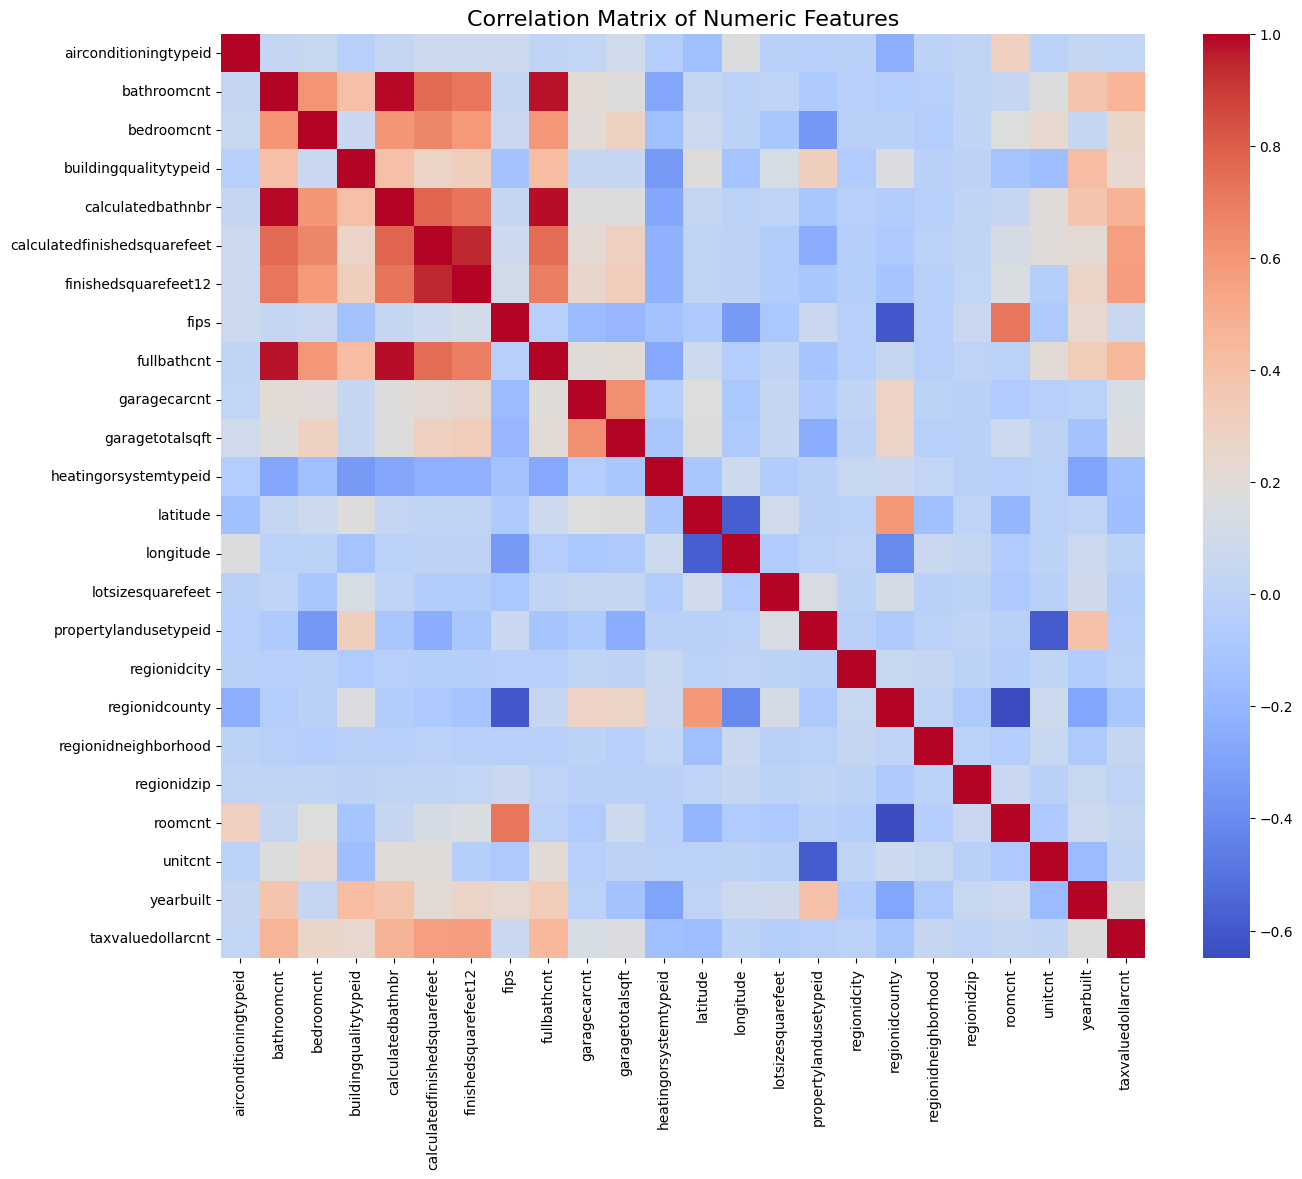

In [49]:
## Compute correlation matrix
corr_matrix = df_encoded.corr()

# Plot correlation matrix
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f", square=True)
plt.title("Correlation Matrix of Numeric Features", fontsize=16)
plt.show()

In [51]:
# Sort features by correlation with target
target_corr = corr_matrix['taxvaluedollarcnt'].drop('taxvaluedollarcnt').sort_values(ascending=False)
print("############################################")
print("Top correlations with target:")
print("############################################\n")
print(target_corr.head(10))

############################################
Top correlations with target:
############################################

finishedsquarefeet12            0.570127
calculatedfinishedsquarefeet    0.563739
calculatedbathnbr               0.473154
bathroomcnt                     0.466647
fullbathcnt                     0.448874
bedroomcnt                      0.264226
buildingqualitytypeid           0.244493
yearbuilt                       0.185935
garagetotalsqft                 0.160988
garagecarcnt                    0.136324
Name: taxvaluedollarcnt, dtype: float64


In [52]:
# Split X and y
X = df_encoded.drop(columns='taxvaluedollarcnt')
y = df_encoded['taxvaluedollarcnt']

# Compute F-statistics
f_scores, p_values = f_regression(X, y)

# Create DataFrame for plotting
f_stats_df = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': f_scores,
    'p-value': p_values
}).sort_values(by='F-Score', ascending=False)

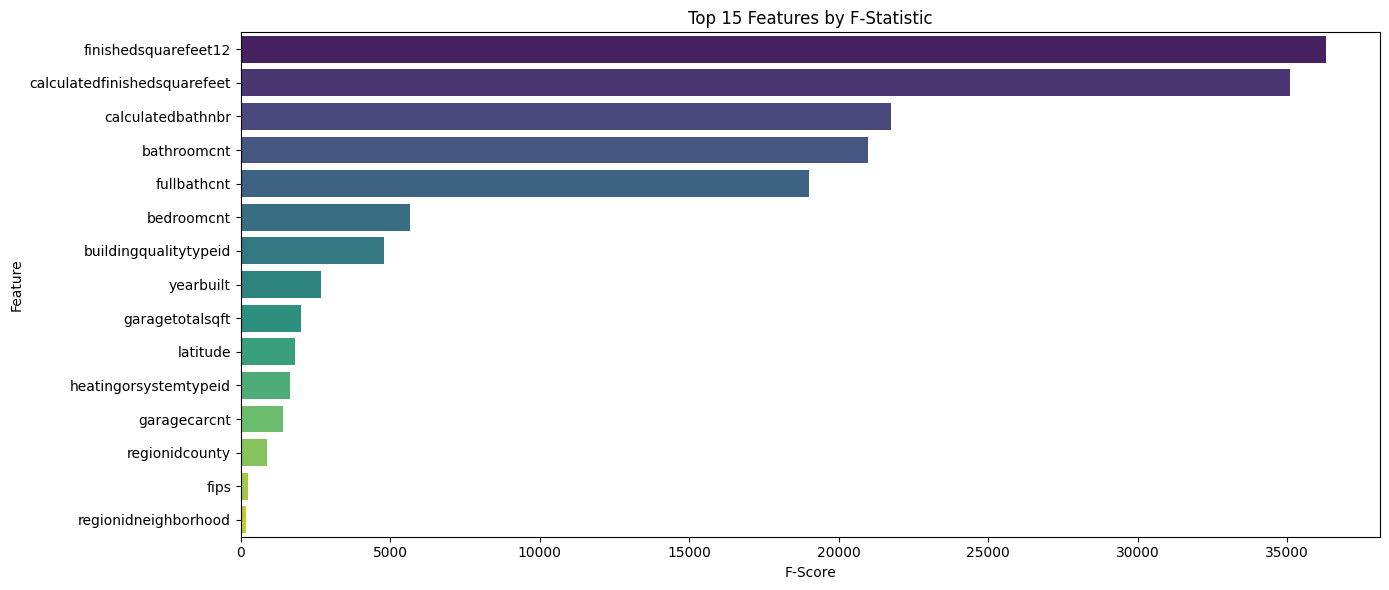

In [70]:
plt.figure(figsize=(14, 6))
sns.barplot(x='F-Score', y='Feature', data=f_stats_df.head(15), hue='Feature', palette='viridis',legend=False)
plt.title('Top 15 Features by F-Statistic')
plt.xlabel('F-Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

##### Identify features with strong correlations or notable relationships that may impact model performance.

1. finishedsquarefeet12
2. calculatedfinishedsquarefeet
3. calculatedbathnbr
4. bathroomcnt
5. fullbathcnt

In [92]:

# Base model
lr = sklearn.linear_model.LinearRegression()

# Forward selection
sfs_forward = SequentialFeatureSelector(lr, direction='forward', n_features_to_select='auto', scoring='r2', cv=5)
sfs_forward.fit(X, y)
forward_selected = X.columns[sfs_forward.get_support()].tolist()
print("###############################################")
print("Forward selection features:") 
print("###############################################\n")
print(forward_selected)
# Backward selection
sfs_backward = SequentialFeatureSelector(lr, direction='backward', n_features_to_select='auto', scoring='r2', cv=5)
sfs_backward.fit(X, y)
backward_selected = X.columns[sfs_backward.get_support()].tolist()
print("###############################################")
print("Backward selection features:")
print("###############################################\n")
print(backward_selected)

###############################################
Forward selection features:
###############################################

['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'garagetotalsqft', 'latitude', 'longitude', 'regionidcounty', 'regionidneighborhood', 'roomcnt']
###############################################
Backward selection features:
###############################################

['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet', 'regionidcounty', 'regionidneighborhood', 'roomcnt']


#### **4.A Discussion:**  Describe in a paragraph what you see in the feature relationships and correlations.

Pay particular attention to especially interesting and/or strongly correlated feature relationships. 
 How do the different methods for seeing relationships compare? Do they agree or disagree?



**The correlation matrix reveals several strong linear relationships between features, particularly among bathroom related variables (bathroomcnt, fullbathcnt, calculatedbathnbr) and finished square footage measures (finishedsquarefeet12, calculatedfinishedsquarefeet). These features also show high positive correlation with the target variable taxvaluedollarcnt, indicating that larger and more equipped homes tend to have higher valuations. The F-statistic analysis further reinforces these findings, with finishedsquarefeet12, calculatedfinishedsquarefeet, and bathroom related features ranking highest in explanatory power. Interestingly, while lotsizesquarefeet showed weaker linear correlation with the target, it was selected in backward feature selection, suggesting it may provide additional non-redundant information when considered jointly with other features. Both forward and backward selection agreed on a core set of influential features such as bathroomcnt, bedroomcnt, buildingqualitytypeid, and latitude/longitude highlighting their consistent predictive value. Overall, these methods largely agree on the key drivers of home value, while offering complementary perspectives: correlation emphasizes linear pairwise strength, F-statistics quantify predictive signal, and feature selection assesses combined modeling contribution.**

### Part 4.B:  2-Dimensional Visualizations for Interesting Patterns  
   - Select three (3) pairs of features that exhibit meaningful relationships based on your previous analysis. 
   - Create 2D scatter plots or density plots to explore interactions between these features.  
   - Provide brief interpretations of any observed patterns or trends. 

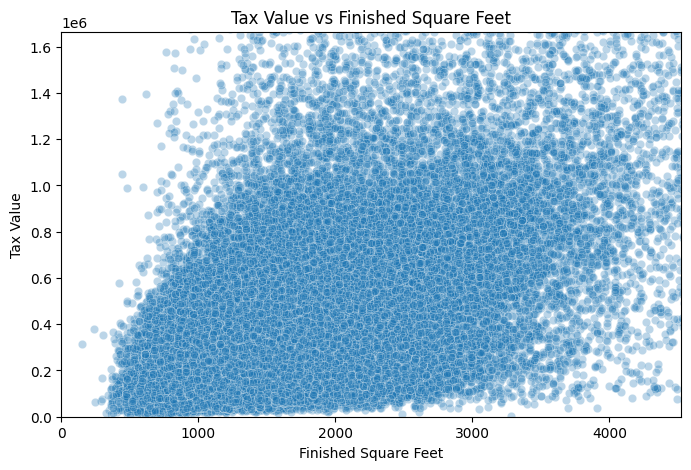

In [61]:
## calculatedfinishedsquarefeet vs taxvaluedollarcnt
plt.figure(figsize=(8, 5))
sns.scatterplot(x='calculatedfinishedsquarefeet', y='taxvaluedollarcnt', data=df_encoded, alpha=0.3)
plt.title('Tax Value vs Finished Square Feet')
plt.xlabel('Finished Square Feet')
plt.ylabel('Tax Value')
plt.xlim(0, df_encoded['calculatedfinishedsquarefeet'].quantile(0.99))
plt.ylim(0, df_encoded['taxvaluedollarcnt'].quantile(0.99))
plt.show()

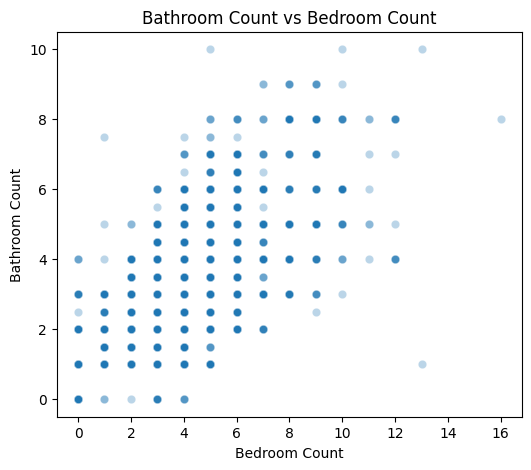

In [62]:
## bedroomcnt vs bathroomcnt
plt.figure(figsize=(6, 5))
sns.scatterplot(x='bedroomcnt', y='bathroomcnt', data=df_encoded, alpha=0.3)
plt.title('Bathroom Count vs Bedroom Count')
plt.xlabel('Bedroom Count')
plt.ylabel('Bathroom Count')
plt.show()

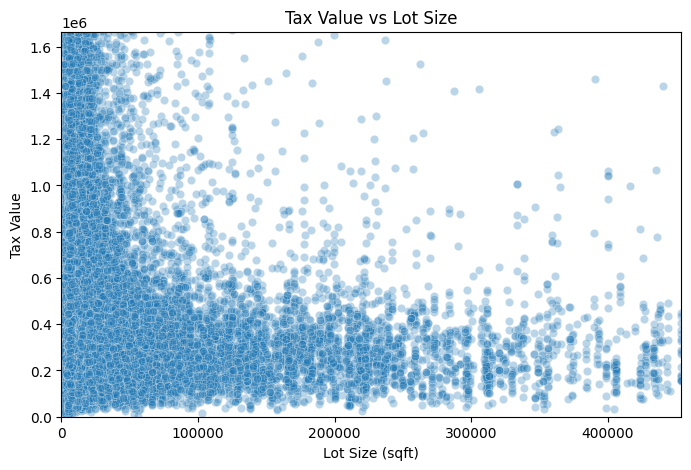

In [63]:

## lotsizesquarefeet vs taxvaluedollarcnt
plt.figure(figsize=(8, 5))
sns.scatterplot(x='lotsizesquarefeet', y='taxvaluedollarcnt', data=df_encoded, alpha=0.3)
plt.title('Tax Value vs Lot Size')
plt.xlabel('Lot Size (sqft)')
plt.ylabel('Tax Value')
plt.xlim(0, df_encoded['lotsizesquarefeet'].quantile(0.99))
plt.ylim(0, df_encoded['taxvaluedollarcnt'].quantile(0.99))
plt.show()

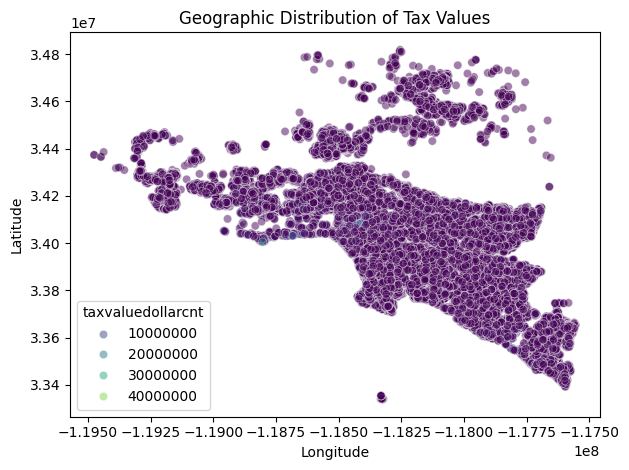

In [93]:
sns.scatterplot(data=df, x='longitude', y='latitude', hue='taxvaluedollarcnt', palette='viridis', alpha=0.5)
plt.title('Geographic Distribution of Tax Values')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()

#### **4.B Discussion:** Provide brief interpretations of any observed patterns or trends.


**The scatter plot of finished square feet vs. tax value reveals a strong positive relationship, with larger homes generally associated with higher property values. However, there’s increasing spread as square footage increases, suggesting greater variability in valuation among large homes. The bathroom count vs. bedroom count plot shows a clear upward trend, indicating that homes with more bedrooms typically have more bathrooms. The structured clustering suggests common home design patterns. Lastly, the lot size vs. tax value plot shows a much weaker relationship, while some high value homes have large lots, many do not. The data is heavily skewed with a long tail, and there appears to be significant overlap between properties of different values at smaller lot sizes. This suggests that lot size alone is not a strong predictor of home value and may interact with other variables like location or building quality. This geographic scatter plot reveals how property values are distributed spatially. Higher-valued properties are clustered in certain regions, indicating that location plays a major role in tax assessment. These clusters likely correspond to wealthier or more desirable neighborhoods. We also noticed that some lower-value properties are more geographically dispersed. This pattern supports the idea that geographic coordinates are crucial for modeling regional market trends.**

## Part 5:  Feature Engineering: Investigate various transformations to better expose the underlying data patterns to machine learning algorithms. [6 pts]

**Important Notes:**  
- This last part is a bit open ended, since there is a huge variety of feature engineering techniques, most of which won't be useful for your particular dataset. 
- Understand that you can't evaluate the final usefulness of these transformations
until you choose a model, and  models may respond differently to various transformations or obviate some transformations (e.g., ensemble methods already do feature selection). 
- Therefore, write your transformations as functions or otherwise be prepared
to choose later on which transformations may be necessary. 

**Investigate feature engineering, where appropriate:**

- Feature scaling: standardize or normalize features as necessary
- Decompose features (e.g., categorical into One-Hot feature sequence, date/time into two features data and time, etc.).
- Add promising transformations of features
    - Exponential $\exp(x_i)$ or logarithmic $\log(x_j)$
    - Polynomial features  ( $x_i^2$, $x_i - x_j$), products ($x_i*x_j$), or ratios ($x_i/x_j$)

**ToDo:**
- Pick at least three transformations to try.
- Try each one and evaluate its effect using correlations or F-scores or a feature selection algorithm.
- Answer the discussion question. 

In [94]:
### Log transform skewed features
### Interaction Feature bedroomcnt * bathroomcnt
### Polynomial Feature calculatedfinishedsquarefeet^2

def engineer_features(df):
    df_fe = df.copy()

    # Log transform skewed features (add 1 to avoid log(0))
    df_fe['log_taxvaluedollarcnt'] = np.log1p(df_fe['taxvaluedollarcnt'])
    df_fe['log_lotsizesquarefeet'] = np.log1p(df_fe['lotsizesquarefeet'])

    # Interaction term
    df_fe['bed_bath_interaction'] = df_fe['bedroomcnt'] * df_fe['bathroomcnt']

    # Polynomial feature
    df_fe['sq_finished_sqft'] = df_fe['calculatedfinishedsquarefeet'] ** 2

    return df_fe

In [95]:
df_engineered = engineer_features(df_encoded)

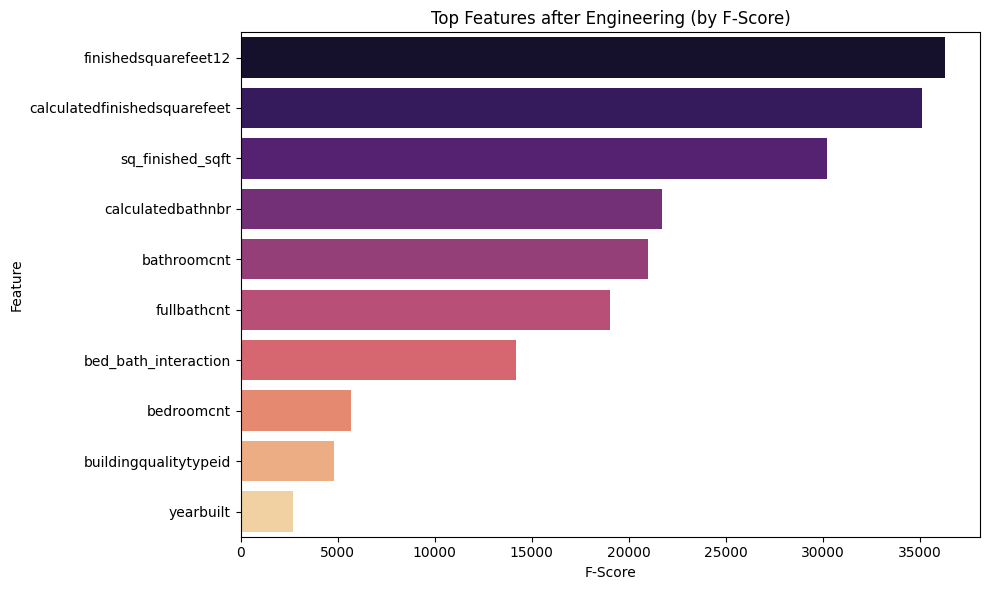

In [97]:
X_fe = df_engineered.drop(columns='taxvaluedollarcnt')  # use new log target later
y_fe = df_engineered['taxvaluedollarcnt']
X_fe = df_engineered.drop(columns=['taxvaluedollarcnt', 'log_taxvaluedollarcnt'])

# Evaluate F-statistic
f_scores_fe, _ = f_regression(X_fe.fillna(0), y_fe)  # fillna for safety
f_stat_df_fe = pd.DataFrame({'Feature': X_fe.columns, 'F-Score': f_scores_fe}).sort_values(by='F-Score', ascending=False)

# Plot top 10
plt.figure(figsize=(10, 6))
sns.barplot(x='F-Score', y='Feature', data=f_stat_df_fe.head(10), hue='Feature',palette='magma', legend=False)
plt.title('Top Features after Engineering (by F-Score)')
plt.tight_layout()
plt.show()

#### **5 Discussion:** Describe in a paragraph why you chose these transformations and what you observed. 


**For this feature engineering step, we selected three transformations based on the data’s distribution and earlier exploratory findings. First, we applied a log transformation to taxvaluedollarcnt and lotsizesquarefeet to reduce right skew and compress extreme values, making patterns more linear and interpretable. Second, we created an interaction feature between bedroomcnt and bathroomcnt to capture potential coorelation between these two common indicators of home size. Third, we introduced a polynomial feature by squaring calculatedfinishedsquarefeet, aiming to model nonlinear effects of home size on value. Upon evaluating these transformations using F-statistics, several engineered features particularly the log transformed target, the polynomial square footage, and the bed/bath interaction showed improved explanatory statistics. These results suggest that well targeted transformations can reveal important underlying structure in the data and should be considered in the next modeling phase.**

## **Appendix 1: Features of the Zillow Dataset**  

0. **parcelid**: Unique identifier for the property parcel.  
1. **airconditioningtypeid**: Identifier for the type of air conditioning installed.  
2. **architecturalstyletypeid**: Identifier for the architectural style of the property.  
3. **basementsqft**: Square footage of the basement.  
4. **bathroomcnt**: Number of bathrooms.  
5. **bedroomcnt**: Number of bedrooms.  
6. **buildingclasstypeid**: Identifier for the building framing type (e.g., wood frame, steel frame).  
7. **buildingqualitytypeid**: Numeric value indicating the quality of the building (higher values often indicate better quality).  
8. **calculatedbathnbr**: Calculated number of bathrooms, including fractional bathrooms.  
9. **decktypeid**: Identifier for the type of deck.  
10. **finishedfloor1squarefeet**: Square footage of the finished area on the first floor.  
11. **calculatedfinishedsquarefeet**: Total finished living area square footage.  
12. **finishedsquarefeet12**: Finished living area square footage.  
13. **finishedsquarefeet13**: Perimeter living area square footage.  
14. **finishedsquarefeet15**: Total area.  
15. **finishedsquarefeet50**: Square footage of the finished area on the upper floors.  
16. **finishedsquarefeet6**: Base unfinished and finished area square footage.  
17. **fips**: Federal Information Processing Standards code, uniquely identifying counties and county equivalents.  
18. **fireplacecnt**: Number of fireplaces.  
19. **fullbathcnt**: Number of full bathrooms.  
20. **garagecarcnt**: Number of cars that can fit in the garage.  
21. **garagetotalsqft**: Total square footage of the garage.  
22. **hashottuborspa**: Indicates if the property has a hot tub or spa.  
23. **heatingorsystemtypeid**: Identifier for the type of heating system.  
24. **latitude**: Latitude coordinate of the property.  
25. **longitude**: Longitude coordinate of the property.  
26. **lotsizesquarefeet**: Lot size in square feet.  
27. **poolcnt**: Number of pools on the property.  
28. **poolsizesum**: Total square footage of all pools.  
29. **pooltypeid10**: Identifier for spa or hot tub.  
30. **pooltypeid2**: Identifier for pool with spa or hot tub.  
31. **pooltypeid7**: Identifier for pool without hot tub or spa.  
32. **propertycountylandusecode**: County land use code for the property.  
33. **propertylandusetypeid**: Identifier for the property land use type.  
34. **propertyzoningdesc**: Description of the property's zoning.  
35. **rawcensustractandblock**: Unprocessed census tract and block identifier.  
36. **regionidcity**: Identifier for the city.  
37. **regionidcounty**: Identifier for the county.  
38. **regionidneighborhood**: Identifier for the neighborhood.  
39. **regionidzip**: Identifier for the ZIP code.  
40. **roomcnt**: Total number of rooms.  
41. **storytypeid**: Identifier for the type of stories in the building (e.g., basement, attic).  
42. **threequarterbathnbr**: Number of 3/4 bathrooms (typically includes a shower but no tub).  
43. **typeconstructiontypeid**: Identifier for the type of construction (e.g., frame, masonry).  
44. **unitcnt**: Number of units in the building (e.g., for multi-family properties).  
45. **yardbuildingsqft17**: Square footage of the 17th yard building (e.g., shed).  
46. **yardbuildingsqft26**: Square footage of the 26th yard building.  
47. **yearbuilt**: Year the property was built.  
48. **numberofstories**: Number of stories in the building.  
49. **fireplaceflag**: Indicates if the property has a fireplace.  
50. **assessmentyear**: Year the property was assessed.  
51. **taxdelinquencyflag**: Indicates whether the property’s taxes are delinquent. Often “Y” if taxes are past due; otherwise null/empty.  
52. **taxdelinquencyyear**: The year in which the property’s taxes became delinquent.  
53. **censustractandblock**: A combined identifier for the property’s census tract and block group (part of the U.S. Census geographic hierarchy).  
54. **taxvaluedollarcnt**: Total assessed value of the property (land plus structure) in dollars.  


## Appendix 2: Summary of Basic Imputation Methods
Imputation depends on the data type and context. Below are common techniques for handling missing values.

---

### **1. Simple Imputation (Basic Methods)**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Drop Missing Values** | Few missing values (<5% of data) | `df.dropna()` | Quick and easy | Can remove valuable data |
| **Mean Imputation** | Normally distributed numerical data | `df.fillna(df.mean())` | Preserves mean; simple | Distorts variance, weak for skewed data |
| **Median Imputation** | Skewed numerical data | `df.fillna(df.median())` | Robust to outliers | May not capture patterns |
| **Mode Imputation** | Categorical features | `df.fillna(df.mode().iloc[0])` | Keeps most common category | Can introduce bias |
| **Constant Value (e.g., 0)** | Special cases (e.g., unknown numerical data) | `df.fillna(0)` | Simple and interpretable | Can mislead model |
| **"Unknown" Category Imputation** (**New Addition**) | Categorical features with missing values | `df.fillna('Unknown')` | Keeps all rows, prevents data loss | May introduce artificial category |

---

### **2. Statistical & Advanced Imputation**
| Method | Best For | Code Example | Pros | Cons |
|--------|---------|--------------|------|------|
| **Interpolation** | Time series, ordered data | `df.interpolate(method='linear')` | Preserves trends | May not work for non-continuous data |
| **K-Nearest Neighbors (KNN)** | Small datasets, patterns in features | `KNNImputer(n_neighbors=5).fit_transform(df)` | Uses similar observations | Computationally expensive |
| **Multivariate Imputation (MICE)** | Complex relationships between variables | `IterativeImputer().fit_transform(df)` | Captures relationships | Slower than mean/median |
| **Regression Imputation** | When missing values depend on other variables | Train regression model to predict missing values | More accurate than mean/median | Risk of overfitting |

---

### **When to Use "Unknown" Category for Categorical Imputation**
✅ **Good for:**
- Categorical features where missing values may indicate meaningful differences.  
- Customer data (e.g., missing survey responses → "No Response").  
- Product categories where missing could be a separate group.  

❌ **Avoid if:**
- The missing category does **not** have a meaningful interpretation.
- The model might learn spurious patterns from an artificial category.

---

### **Which Method to Choose?**
| Scenario | Best Method |
|----------|------------|
| **Few missing values (<5%)** | Drop NaNs (`df.dropna()`) |
| **Numerical & normal distribution** | Mean (`df.fillna(df.mean())`) |
| **Numerical & skewed distribution** | Median (`df.fillna(df.median())`) |
| **Categorical features** | Mode (`df.fillna(df.mode().iloc[0])`) |
| **Categorical with possible meaning in missingness** | "Unknown" Category (`df.fillna('Unknown')`) |
| **Small dataset with patterns** | KNN Imputer (`KNNImputer()`) |
| **Complex relationships between features** | MICE / Iterative Imputer |

